## Import Packages

In [63]:
#!rm -r logs

In [1]:
# IMPORT TENSORFLOW
import tensorflow as tf

# IMPORT KERAS
import keras
from keras import regularizers
from keras.applications import EfficientNetV2B2, efficientnet
from keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# IMPORT OTHERS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io

from io import BytesIO
from PIL import Image

In [2]:
!git clone https://github.com/GitKentC/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 43233, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 43233 (delta 114), reused 293 (delta 113), pack-reused 42938 (from 1)
Receiving objects: 100% (43233/43233), 1.13 GiB | 23.84 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Updating files: 100% (162310/162310), done.


## Loading Data

In [66]:
"""
DATASET VARIABLES (FOR COLAB)
1. garbage_classification
2. garbage_classification_lite (reduced to 1250 images max for each class; 12 classes)
3. garbage_concat
4. garbage_concat_lite (reduced to 850 images max for each class; 18 classes)
"""
# """ DATASET VARIABLES (FOR LOCAL)"""
# DATASET_NAME = 'garbage_classification'
# DATASET_DIR = f'../dataset/dupe_cleaned/{DATASET_NAME}'
# TRAIN_DIR = f'../dataset/split/{DATASET_NAME}/train'
# VALIDATION_DIR = f'../dataset/split/{DATASET_NAME}/validation'
# TEST_DIR = f'../dataset/split/{DATASET_NAME}/test'

'\nDATASET VARIABLES (FOR COLAB)\n1. garbage_classification\n2. garbage_classification_lite (reduced to 1250 images max for each class; 12 classes)\n3. garbage_concat\n4. garbage_concat_lite (reduced to 850 images max for each class; 18 classes)\n'

In [3]:
""" DATASET VARIABLES (FOR COLAB)"""
DATASET_DIR = '/content/dataset/dupe_cleaned/garbage_classification_lite'
TRAIN_DIR = '/content/dataset/split/garbage_classification_lite/train'
VALIDATION_DIR = '/content/dataset/split/garbage_classification_lite/validation'
TEST_DIR = '/content/dataset/split/garbage_classification_lite/test'

In [4]:
""" Change this to match pre-trained models input; for consistency """
IMAGE_SIZE:tuple[int,int] = (256, 256)
BATCH_SIZE:int = 64
LABEL_MODE:str = 'categorical'
COLOR_MODE:str = 'rgb'

def load_datasets_split():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True
    )

    return train_dataset, validation_dataset, test_dataset

In [5]:
""" Create datasets """
train_ds, val_ds, test_ds = load_datasets_split()

Found 6948 files belonging to 10 classes.
Found 1983 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


## Transforming Data

In [6]:
""" Preprocess the data  """
def preprocess(image, label):
    # CenterCrop after resizing the smallest
    image = keras.layers.Resizing(256, 256, pad_to_aspect_ratio=True)(image)
    image = keras.layers.CenterCrop(224, 224)(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image, label

train_ds_prep = train_ds.map(preprocess)
val_ds_prep = val_ds.map(preprocess)
test_ds_prep = test_ds.map(preprocess)

In [7]:
def check_min_max(ds):
    for image_batch, label_batch in ds.take(1):
        min_val = tf.reduce_min(image_batch).numpy()
        max_val = tf.reduce_max(image_batch).numpy()
        print(f"Min value: {min_val}, Max value: {max_val}")

check_min_max(train_ds)
print()
check_min_max(train_ds_prep)

Min value: 0.0, Max value: 255.0

Min value: -1.0, Max value: 1.0


In [8]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_ds_final = (train_ds_prep
                  .cache()
                  .shuffle(SHUFFLE_BUFFER_SIZE)
                  .prefetch(PREFETCH_BUFFER_SIZE)
                  )

val_ds_final = (val_ds_prep
                .cache()
                .prefetch(PREFETCH_BUFFER_SIZE)
                )

test_ds_final = (test_ds_prep
                .cache()
                .prefetch(PREFETCH_BUFFER_SIZE)
                )

## Preparing Inference Model

In [9]:
def create_pre_trained_model():
    pre_trained_model = EfficientNetV2B2(
        include_top = False,
        input_shape = (224,224,3),
        weights = "imagenet",
        include_preprocessing = False,
    )

    start_freezing_layer_name = 'block6a_expand_conv'

    freeze = True
    for layer in pre_trained_model.layers:
        if layer.name == start_freezing_layer_name:
            freeze = False
        layer.trainable = not freeze

    for layer in pre_trained_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    return pre_trained_model

pre_trained_model = create_pre_trained_model()
pre_trained_model.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1b_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 6,532,882 (24.92 MB)

 Non-trainable params: 2,236,492 (8.53 MB)

In [10]:
last_output = pre_trained_model.output

print('Last layer output shape: ', last_output.shape)

Last layer output shape:  (None, 7, 7, 1408)


In [11]:
def create_augmentation_model():
    FILL_MODE = 'nearest'

    augmentation_model = tf.keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2, fill_mode = FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode = FILL_MODE),
    ])

    return augmentation_model

augmentation_model = create_augmentation_model()

In [15]:
def create_model(augmentation_model, pre_trained_model):
    input = tf.keras.Input(shape=(224, 224, 3))

    x = augmentation_model(input)
    x = pre_trained_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    X = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    model = tf.keras.Model(inputs = input, outputs = output)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-4),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [16]:
model = create_model(augmentation_model, pre_trained_model)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 7, 7, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          14,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,783,464 (33.51 MB)

 Trainable params: 6,546,972 (24.97 MB)

 Non-trainable params: 2,236,492 (8.53 MB)

In [17]:
log_dir = 'logs/efficientv2-b2_tuning'

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0033,
    patience = 10,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 1e-10,
    verbose = 1
)

tensorboard_callback = TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [18]:
history = model.fit(train_ds_final,
                    validation_data = val_ds_final,
                    epochs = 100,
                    verbose = 2,
                    callbacks = [tensorboard_callback,
                                 reduce_lr,
                                 early_stopping]
                    )

Epoch 1/100
109/109 - 81s - 742ms/step - accuracy: 0.6392 - loss: 1.1367 - val_accuracy: 0.8870 - val_loss: 0.3946 - learning_rate: 1.0000e-04
Epoch 2/100
109/109 - 34s - 315ms/step - accuracy: 0.8345 - loss: 0.5282 - val_accuracy: 0.9254 - val_loss: 0.2533 - learning_rate: 1.0000e-04
Epoch 3/100
109/109 - 40s - 368ms/step - accuracy: 0.8749 - loss: 0.3855 - val_accuracy: 0.9365 - val_loss: 0.2102 - learning_rate: 1.0000e-04
Epoch 4/100
109/109 - 42s - 383ms/step - accuracy: 0.9047 - loss: 0.3097 - val_accuracy: 0.9380 - val_loss: 0.1999 - learning_rate: 1.0000e-04
Epoch 5/100
109/109 - 33s - 306ms/step - accuracy: 0.9165 - loss: 0.2589 - val_accuracy: 0.9491 - val_loss: 0.1785 - learning_rate: 1.0000e-04
Epoch 6/100
109/109 - 42s - 383ms/step - accuracy: 0.9252 - loss: 0.2314 - val_accuracy: 0.9541 - val_loss: 0.1581 - learning_rate: 1.0000e-04
Epoch 7/100
109/109 - 33s - 305ms/step - accuracy: 0.9351 - loss: 0.1993 - val_accuracy: 0.9465 - val_loss: 0.1843 - learning_rate: 1.0000e-04

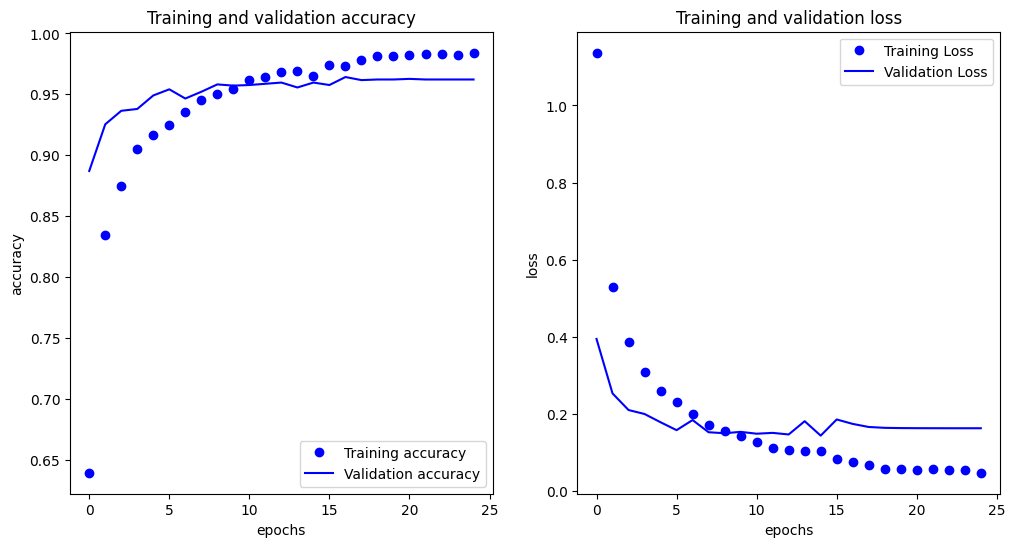

In [19]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [20]:
loss, accuracy = model.evaluate(test_ds_final, verbose=1)
print("Test Accuracy:", accuracy)
print("Test Loss:", loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9547 - loss: 0.1373
Test Accuracy: 0.9549999833106995
Test Loss: 0.15235844254493713


In [21]:
model_name = 'efficientnetv2_b2_waste_finetune_64.keras'
tf.keras.models.save_model(model, model_name)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step


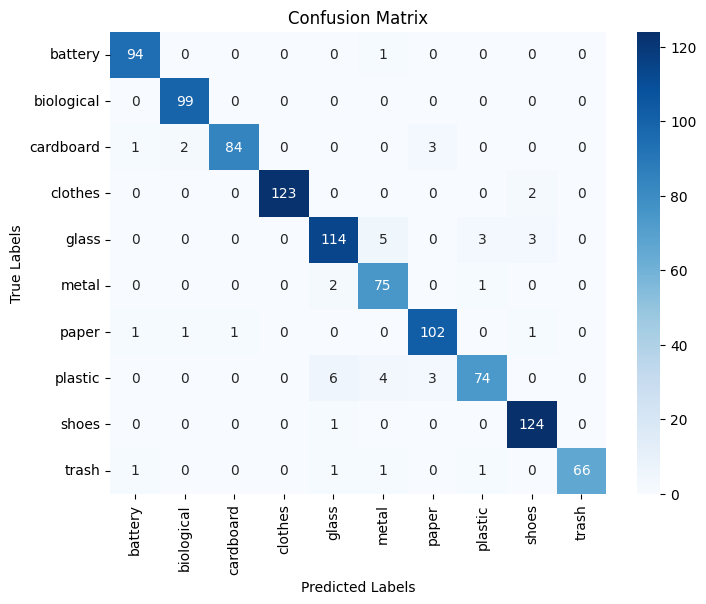

In [22]:
true_labels = np.concatenate([y for x, y in test_ds_final])

# Convert true_labels from one-hot encoding to class indices
true_labels = np.argmax(true_labels, axis=1)

pred_probs = model.predict(test_ds_final)

pred_labels = np.argmax(pred_probs, axis=1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## PREDICT

In [23]:
model = keras.models.load_model('efficientnetv2_b2_waste_finetune_64.keras')

In [24]:
def load_image(image_path):
    with open(image_path, 'rb') as file:
        image_bytes = file.read()
        pillow_img = Image.open(io.BytesIO(image_bytes))
    return pillow_img

def transform(image):
    data = np.asarray(image)
    data = np.float32((data / 127.5) - 1)
    data = np.expand_dims(data, axis=0)

    data = keras.layers.Resizing(256, 256, pad_to_aspect_ratio=True)(data)
    data = keras.layers.CenterCrop(224, 224)(data)
    return data

In [25]:
class_names = [ name for name in train_ds.class_names ]
print(class_names)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [87]:
#class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

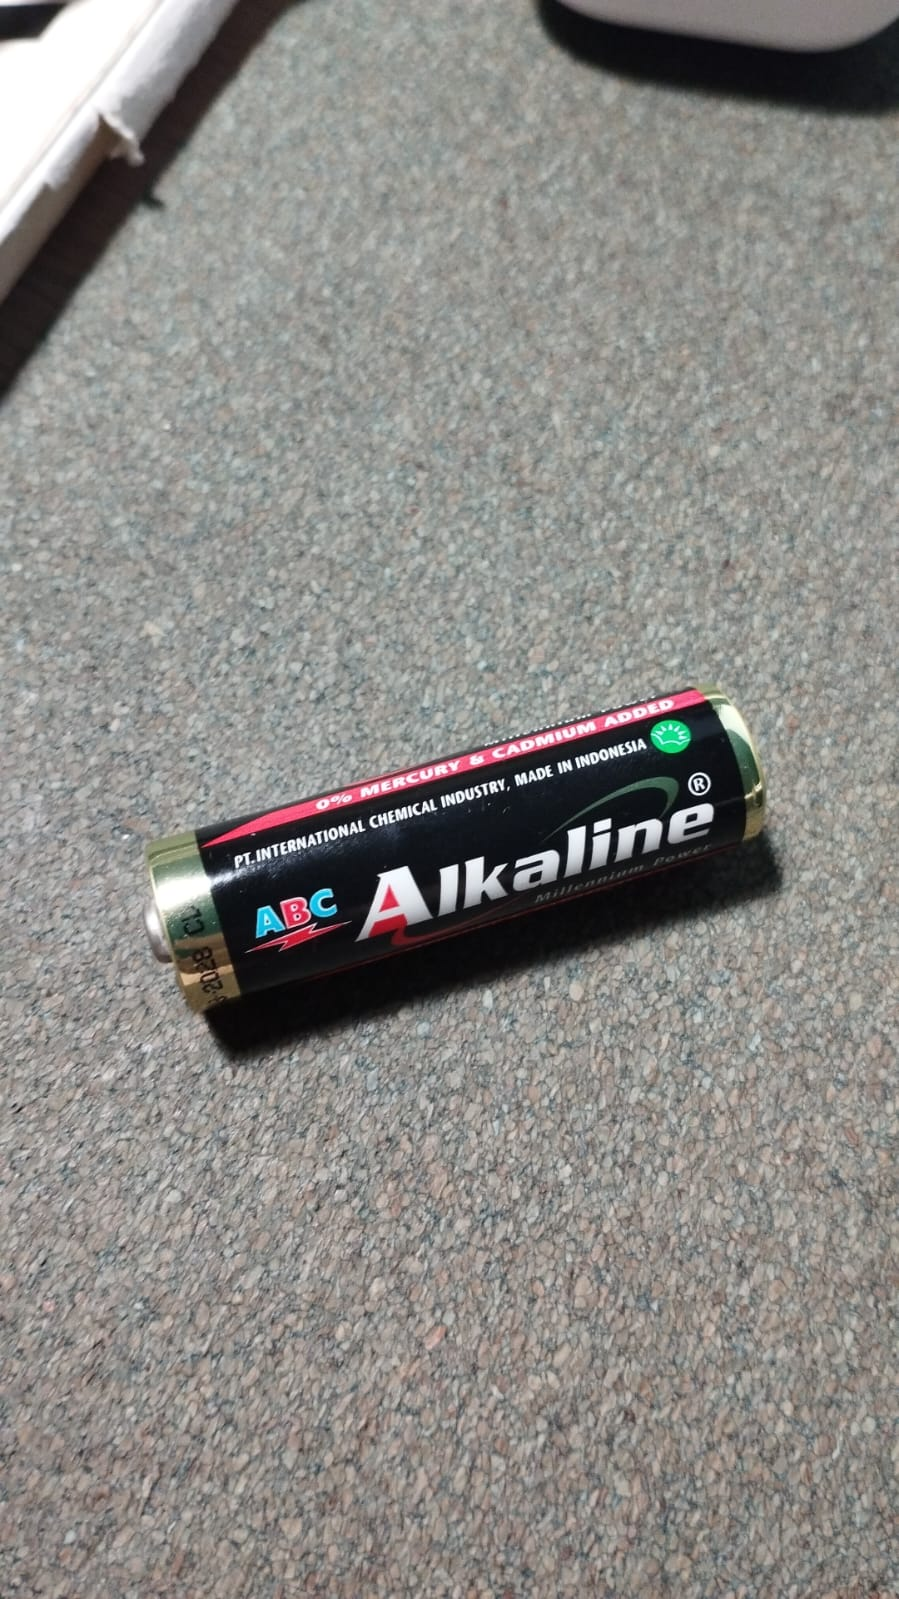

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Rank   Class Name           Confidence  
----------------------------------------
1      battery              1.0000      
2      paper                0.0000      
3      cardboard            0.0000      
4      metal                0.0000      
5      trash                0.0000      
6      biological           0.0000      
7      clothes              0.0000      
8      glass                0.0000      
9      shoes                0.0000      
10     plastic              0.0000      


In [36]:
image = load_image('battery_tamara.jpeg')

display(image)

image = transform(image)

prediction = model.predict(image)
prediction_sort = np.argsort(prediction[0])[::-1]
prediction_names = [class_names[i] for i in prediction_sort]
prediction_confidence = prediction[0][prediction_sort]

print(f"{'Rank':<6} {'Class Name':<20} {'Confidence':<12}")
print("-" * 40)
# Print the top 3 predictions
for i in range(len(prediction_sort)):
    print(f"{i+1:<6} {prediction_names[i]:<20} {prediction_confidence[i]:<12.4f}")